Epoch 1/150


c:\Users\Natha\anaconda3\envs\IR_pv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3737 - val_loss: 0.1215
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1272 - val_loss: 0.0922
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1183 - val_loss: 0.0883
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1082 - val_loss: 0.0853
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1095 - val_loss: 0.0855
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1050 - val_loss: 0.0934
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1046 - val_loss: 0.0837
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1002 - val_loss: 0.0855
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1036 - val_loss: 0.0802
Epoch 10/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1037 - val_loss: 0.0917
Epoch 11/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1007 - val_loss: 0.0817
Epoch 12/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0998 - 

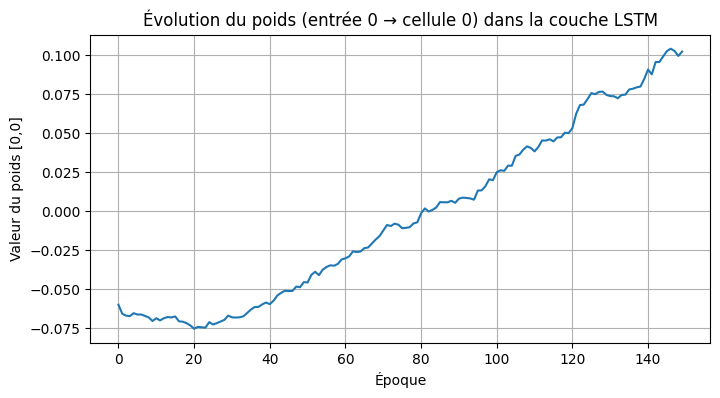

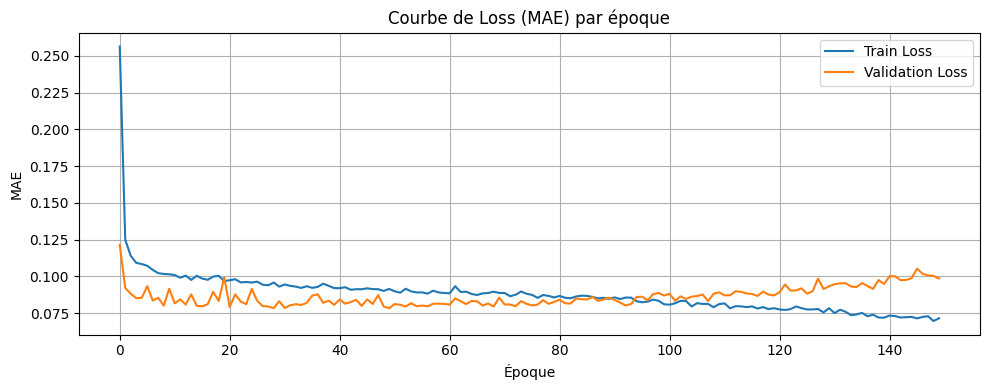

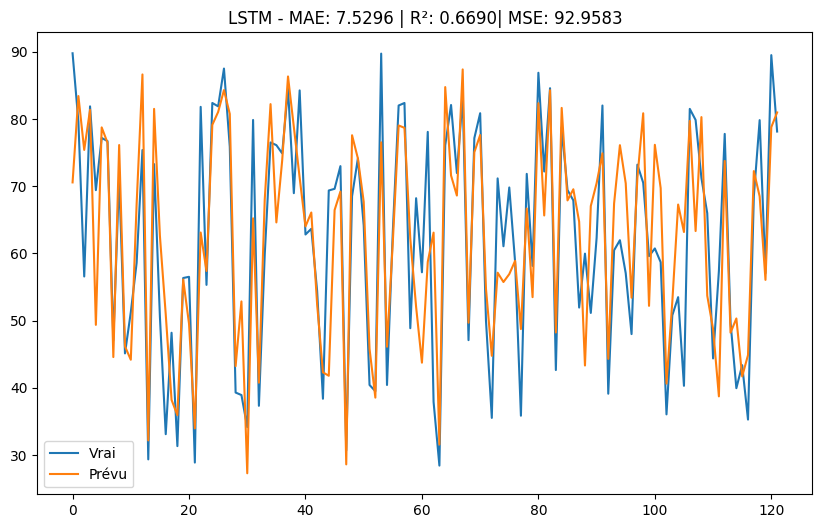

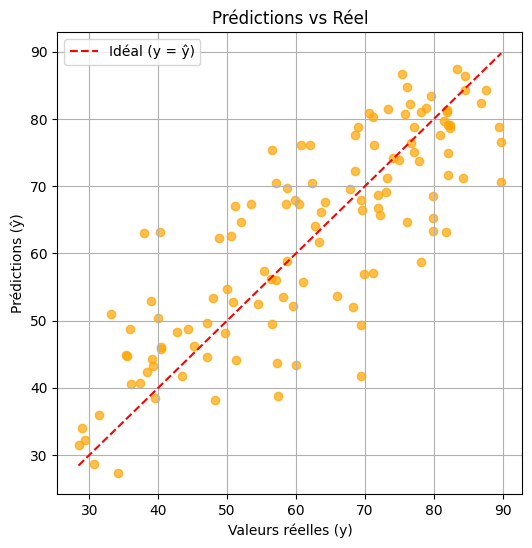

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


class WeightLogger(Callback):
    def __init__(self, layer_name="lstm"):
        super().__init__()
        self.layer_name = layer_name
        self.weights_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        # On récupère la couche par nom
        for layer in self.model.layers:
            if self.layer_name in layer.name.lower():
                weights = layer.get_weights()[0]  # poids des entrées
                self.weights_per_epoch.append(weights.copy())
                break
            
            
# === 1. Chargement des données ===
df = pd.read_csv("../DataCleaning/scaled_dataset.csv")  # Remplace par ton CSV réel
#df = pd.read_csv("../DataCleaning/A - CSV par bâtiment/batiment_1.csv")  # Remplace par ton CSV réel

# === 2. Normalisation ===
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
y_scaled = scaled_df['production']
X_scaled = scaled_df.drop(columns=['production'])

# === 3. Création des séquences temporelles ===
def create_sequences(X, y, window_size=7):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 21
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# === 4. Split train/test ===
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# === 5. Définition du modèle LSTM ===
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer=Adam(0.001), loss='mae')

# === 6. Entraînement ===
weight_logger = WeightLogger(layer_name="lstm")  # nom de la couche

history = model.fit(
    X_train, y_train,
    epochs=700,  
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    callbacks=[weight_logger]
)
# === 7. Prediction ===
y_pred = model.predict(X_test).flatten()

# Inverse scaling des prédictions
n_features = scaled_df.shape[1]
dummy = np.zeros((len(y_pred), n_features))
target_idx = scaled_df.columns.get_loc('production')  # ou passe target_col en argument
dummy[:, target_idx] = y_pred
y_pred_real = scaler.inverse_transform(dummy)[:, target_idx]

dummy_test = np.zeros((len(y_test), n_features))
dummy_test[:, target_idx] = y_test
y_test_real = scaler.inverse_transform(dummy_test)[:, target_idx]

mae = mean_absolute_error(y_test_real, y_pred_real)
mse = np.mean((y_test_real - y_pred_real) ** 2)
r2 = r2_score(y_test_real, y_pred_real)



# === 8. Affichage ===

#Poids des parametres
# Prendre le poids [0, 0] (entrée 0 → cellule 0)
w00 = [w[0, 0] for w in weight_logger.weights_per_epoch]

plt.figure(figsize=(8, 4))
plt.plot(w00)
plt.xlabel("Époque")
plt.ylabel("Valeur du poids [0,0]")
plt.title("Évolution du poids (entrée 0 → cellule 0) dans la couche LSTM")
plt.grid(True)
plt.show()

# Courbe loss 
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Loss (MAE) par époque')
plt.xlabel('Époque')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Performance du modèle
plt.figure(figsize=(10, 6))
plt.plot(y_test_real, label="Vrai")
plt.plot(y_pred_real, label="Prévu")
plt.legend()
plt.title(f"LSTM - MAE: {mae:.4f} | R²: {r2:.4f}| MSE: {mse:.4f}")
plt.show()


# 1. Scatter plot (prédictions vs réel)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_real, y_pred_real, alpha=0.7, color='orange')
plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], 'r--', label="Idéal (y = ŷ)")
plt.xlabel("Valeurs réelles (y)")
plt.ylabel("Prédictions (ŷ)")
plt.title("Prédictions vs Réel")
plt.legend()
plt.grid(True)
plt.show()



Affichage des stats du Dataframe prediction vs reel

In [23]:
StatsDf = pd.DataFrame({
    "Y_test": y_test_real,
    "Y_pred": y_pred_real,
    "Error": y_test_real - y_pred_real,
    "Error_Percent": abs(y_test_real - y_pred_real) / y_test_real * 100
})

print(StatsDf.describe())


           Y_test      Y_pred       Error  Error_Percent
count  122.000000  122.000000  122.000000     122.000000
mean    61.992008   62.362992   -0.370984      13.282225
std     16.826931   15.281689    9.674076      11.853486
min     28.425000   27.281479  -25.204041       0.005463
25%     49.087500   49.574361   -5.665935       3.980720
50%     63.062500   64.984742   -1.125862      11.247365
75%     76.425000   75.944299    4.405191      18.740947
max     89.800000   87.397533   27.577669      66.501427


Histogramme de Erreur

<Axes: >

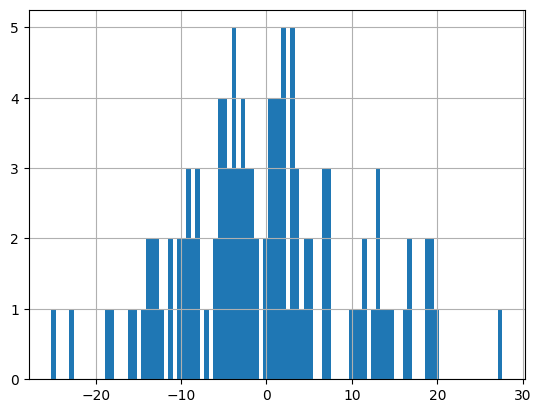

In [24]:
StatsDf['Error'].hist(bins=100)